In [102]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import json
import numpy as np
from matplotlib import pyplot
# import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

In [2]:
case_data = pd.read_csv("../data/case.csv", index_col=False)
print(case_data.shape)
tenacy_data = pd.read_csv("../data/tenancy.csv", index_col=False)
print(tenacy_data.shape)
vulnerability_data = pd.read_csv("../data/vulnerability.csv", index_col=False)
print(vulnerability_data.shape)

(46301, 7)
(11102, 4)
(4315, 2)


# Functions

In [103]:
def transform_list(input_list:list, trans_dict:dict):
    trans_list = [trans_dict[elem] for elem in input_list]
    return list( set(trans_list))

def estimate_date_from_days(days):
    (year, days_remaining) =  divmod(days, 365)
    (months, days_remaining) = divmod(days_remaining, 30)
    days = days_remaining
    return f'{year} years, {months} months, {days} days'

def one_hot_encode_list(df:pd.DataFrame, column:str):
    binarizer = MultiLabelBinarizer().fit(df[column])
    vector_df = pd.DataFrame(binarizer.transform(df[column]), columns=binarizer.classes_)

    return vector_df

def read_json_as_dict(json_file_name:str):
    with open(json_file_name) as d:
        dict_name = json.load(d)
    return dict_name

def save_dict_as_json(json_file_name:str, dict_to_save:dict):
    with open(json_file_name, "w") as outfile:
        json.dump(dict_to_save, outfile)

def save_accuracy_to_dict(input_dict:dict, model:str, features_list:list, accuracy:float):
    try:
        dict_to_save_outputs[model]
    except:
        dict_to_save_outputs[model] = {}
    finally:
        dict_to_save_outputs[model][str(features_list)] = accuracy
    return dict_to_save_outputs

def classify_data(model:str, X_train:pd.DataFrame, X_test:pd.DataFrame, y_train:pd.DataFrame, y_test:pd.Series):
    if model == 'LR':
        print(model)
        classifier = LogisticRegression()
    elif model == 'RF':
        print(model)
        classifier = RandomForestClassifier(random_state=7)
    elif model == 'XGBoost':
        print(model)
        classifier = XGBClassifier(max_depth = 8, n_estimators=200, learning_rate=0.1)
    else:
        print("The classifier that you chose does not exist - setting default classifier which is Logistc Regression")
        classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    accuracy = round(classifier.score(X_test, y_test), 4)
    precision = precision_score(y_test, y_pred)
    print('Accuracy of {} classifier on test set: {:.4f}'.format(model, accuracy))

    return (classifier, y_pred, accuracy, precision)

def estimate_probability(classifier, input_df:pd.DataFrame):
    labels_mapping = pd.DataFrame(classifier.classes_).reset_index().rename(columns = {'index': 'classifier_numbers', 0: 'labels'})
    labels_dict = dict(zip(labels_mapping['classifier_numbers'], labels_mapping['labels']))
    proba_with_labels = pd.DataFrame(classifier.predict_proba(input_df)).rename(columns = labels_dict)
    return proba_with_labels[1]

# Vulnerability

In [4]:
# Vulnerability
vulnerability_data
print("There are {} tenants in our database".format(vulnerability_data['tenancy_id'].drop_duplicates().shape[0]))
print("Each tenant can have more than one vulnerability")
vulnerability_data['Vulnerability'].value_counts()

There are 2683 tenants in our database
Each tenant can have more than one vulnerability


Illness                  914
Physical Support         668
Mental Health            538
Elderly                  391
COVID Self Isolation     299
Tenancy Support          211
Caution                  173
Wheelchair Support       171
Language Support         166
Learning difficulties    156
Tenancy Verification     139
Sight                    136
COVID 12wk Shielding     125
Hearing                  111
Domestic Violence         53
Drug/Alcohol              51
Young Person              11
Child Protection           2
Name: Vulnerability, dtype: int64

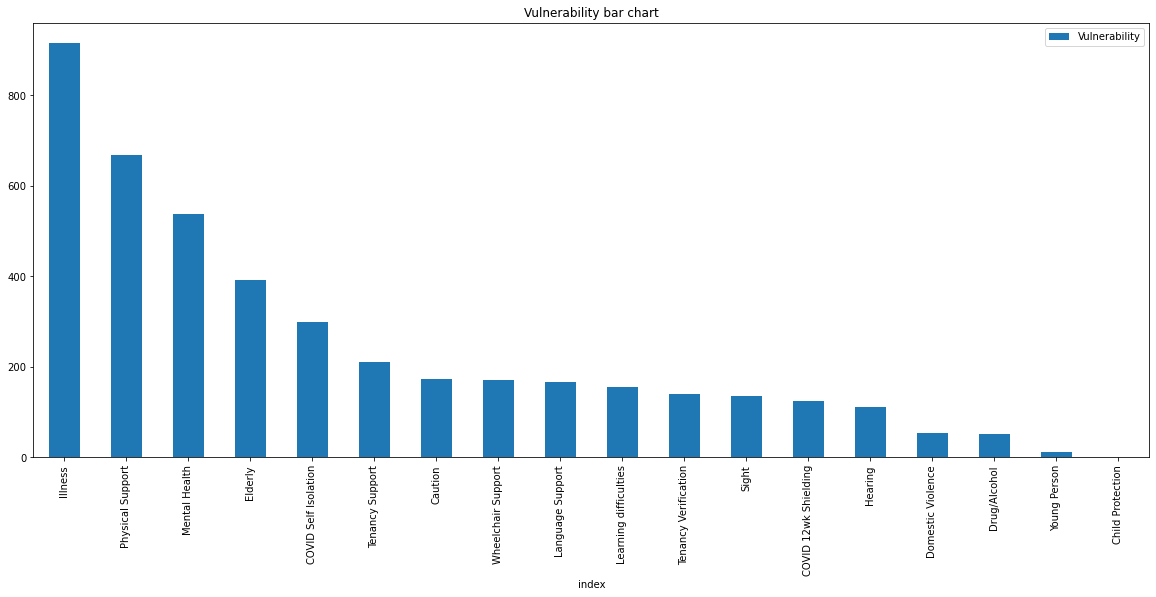

In [43]:
vulnerability_data['Vulnerability'].value_counts().reset_index().sort_values('Vulnerability', ascending = False).set_index('index').plot.bar(figsize = (20,8), title = "Vulnerability bar chart")

I grouped together the vulnerabilities into categories, because I though that movement vulnerabilities could impact more someone from cleaning their apartment therefore increase the chance of mould.

Below there are two different groupings that I came with

In [5]:
# Groupng 1
diff_dict = {'movement_difficulty': ['Physical Support', 'Elderly', 'Wheelchair Support', 'Sight'],
 'health_risk': ['COVID 12wk Shielding'],
 'communication_difficulty': ['Language Support', 'Hearing'],
 'mental_difficulty': ['Mental Health', 'Learning difficulties', 'Drug/Alcohol', 'Domestic Violence'],
 'temp_vulnerability': ['COVID Self Isolation', 'Tenancy Verification'],
 'generic': ['Illness', 'Caution', 'Young Person', 'Child Protection', 'Tenancy Support']
             }
# I have to understand bettter what is tenacy support and tenacy verifications

In [6]:
# Grouping 2
diff_dict2 = {'movement_difficulty': ['Physical Support', 'Elderly', 'Wheelchair Support'], # people who can not clean because of physical barriers
             'covid': ['COVID 12wk Shielding', 'COVID Self Isolation'], #
             'communication_difficulty': ['Language Support', 'Hearing', 'Sight'],
             'mental_difficulty': ['Mental Health',],
             'abuse_addiction' : ['Drug/Alcohol', 'Domestic Violence'],
              'family_difficulty' : ['Young Person', 'Child Protection'],
              'generic': ['Illness', 'Caution', 'Tenancy Verification'],
              'other' : ['Tenancy Support', 'Learning difficulties']
}

In [7]:
# Dictionary with vulnerability as key and the type of vulnerability (eg. movement difficulty) as value
difficulty_type_dict = {}
for key,value in diff_dict.items():
    for elem in value:
        difficulty_type_dict[elem] = key
print(len(difficulty_type_dict))

difficulty_type_dict2 = {}
for key,value in diff_dict2.items():
    for elem in value:
        difficulty_type_dict2[elem] = key
print(len(difficulty_type_dict2))

18
18


In [8]:
# Transform the format of the data so all the vulnerabilites of a tenant is in the same row
vulnerability_type = 'v2'
vulnerability_data_packed = vulnerability_data.groupby(['tenancy_id'])['Vulnerability'].apply(list).reset_index()
vulnerability_data_packed
# Assign type of disease for each submisison
if vulnerability_type == 'v1':
    vulnerability_data_packed['Vulnerability type'] = vulnerability_data_packed['Vulnerability'].apply(lambda x : transform_list(x, difficulty_type_dict))
elif vulnerability_type == 'v2':
    vulnerability_data_packed['Vulnerability type'] = vulnerability_data_packed['Vulnerability'].apply(lambda x : transform_list(x, difficulty_type_dict2))

In [9]:
vulnerability_data_packed.head()

,tenancy_id,Vulnerability,Vulnerability type
0,Tenant1000,[COVID Self Isolation],[covid]
1,Tenant10006,"[COVID Self Isolation, COVID Self Isolation]",[covid]
2,Tenant10025,[Language Support],[communication_difficulty]
3,Tenant1003,"[Illness, Physical Support, Sight, Mental Health]","[movement_difficulty, communication_difficulty..."
4,Tenant10039,[Mental Health],[mental_difficulty]


# Tenancy

In [10]:
# New columns
# 1) Convert the date fields from strings to datetime type
# 2) Label each tenancy whether it is Open(active) or closed
# 3) Estimate the duration of the tenancy
tenacy_data['tenancy_start_date_as_date'] = tenacy_data['tenancy_start_date'].apply(lambda x :  datetime.strptime(x, '%d/%m/%Y'))
tenacy_data['tenancy_end_date_as_date'] = tenacy_data['tenancy_end_date'].apply(lambda x :  x if str(x) == 'nan' else datetime.strptime(x, '%d/%m/%Y'))
tenacy_data['Status'] =tenacy_data['tenancy_end_date'].apply(lambda x : "Open" if str(x) == 'nan' else 'Closed')
tenacy_data['tenancy_duration (days)'] = tenacy_data.apply(lambda row : (datetime.now() - row['tenancy_start_date_as_date']).days if str(row['tenancy_end_date']) == 'nan' else (row['tenancy_end_date_as_date'] - row['tenancy_start_date_as_date']).days, axis =1 )
tenacy_data['tenacy_duration (months)'] = tenacy_data['tenancy_duration (days)'].apply(lambda x : round(x/30,0))
tenacy_data['tenacy_duration (6- months)'] = tenacy_data['tenancy_duration (days)'].apply(lambda x : round(x/180,0))
tenacy_data['tenacy_duration (years)'] = tenacy_data['tenancy_duration (days)'].apply(lambda x : round(x/365,0))

In [11]:
# Tenacy (historical table)
print("There are {} properties in our database".format(tenacy_data['unit_ref'].drop_duplicates().shape[0]))
print("There are {} active contracts".format(tenacy_data[tenacy_data['tenancy_end_date'].isnull()].shape[0]))
print("There are {} closed contracts".format(tenacy_data[~tenacy_data['tenancy_end_date'].isnull()].shape[0]))
print("The median duration of closed contracts is {}".format(estimate_date_from_days(tenacy_data[~tenacy_data['tenancy_end_date'].isnull()]['tenancy_duration (days)'].median())))
print("The mean duration of closed contracts is {}".format(estimate_date_from_days(tenacy_data[~tenacy_data['tenancy_end_date'].isnull()]['tenancy_duration (days)'].mean())))
# number of open contracts
# number of closed contracts
# average duration of contract
# check that there are not tenants leaving in the same apartment

There are 9956 properties in our database
There are 9404 active contracts
There are 1698 closed contracts
The median duration of closed contracts is 6.0 years, 1.0 months, 19.0 days
The mean duration of closed contracts is 8.0 years, 11.0 months, 28.63309776207325 days


In [12]:
# More than one tenants might be living in the same apartment
co_living_tenants = tenacy_data.groupby(['unit_ref', 'tenancy_start_date'])[['tenancy_id']].count().sort_values('tenancy_id', ascending = False)#[]#['tenancy_start_date'].max()
co_living_tenants[co_living_tenants['tenancy_id'] > 1]

,,tenancy_id
unit_ref,tenancy_start_date,
Unit6829,22/08/2019,2
Unit7757,13/11/2020,2
Unit9601,12/11/2018,2


In [13]:
# Sequence of tenants living in the apartment # TODO - this can be used as a feature but careful with merging - use timestamp as well
tenancy_chain = (tenacy_data.groupby(['unit_ref']).agg({'tenancy_id': lambda x: ', '.join(x)}).reset_index()
                 .rename(columns = {'tenancy_id' : 'sequence_of_tenants'}))
tenancy_chain['number_of_tenants'] = tenancy_chain['sequence_of_tenants'].apply(lambda x : len(x.split(',')))
# tenancy_chain.sort_values('number_of_tenants', ascending = False)
tenancy_chain['number_of_tenants'].value_counts()

1    8856
2    1058
3      38
4       4
Name: number_of_tenants, dtype: int64

In [14]:
tenancy_chain.sort_values('number_of_tenants', ascending = False)

,unit_ref,sequence_of_tenants,number_of_tenants
6044,Unit6460,"Tenant5001, Tenant5002, Tenant5003, Tenant5004",4
1114,Unit2005,"Tenant7503, Tenant7504, Tenant7505, Tenant7506",4
7238,Unit7544,"Tenant913, Tenant914, Tenant915, Tenant916",4
5571,Unit6033,"Tenant2458, Tenant2459, Tenant2460, Tenant2461",4
9044,Unit9175,"Tenant4071, Tenant4072, Tenant4073",3
...,...,...,...
3502,Unit4166,Tenant10124,1
3503,Unit4167,Tenant10651,1
3504,Unit4168,Tenant2229,1
3505,Unit4169,Tenant10866,1


## Tenacy duration distributions

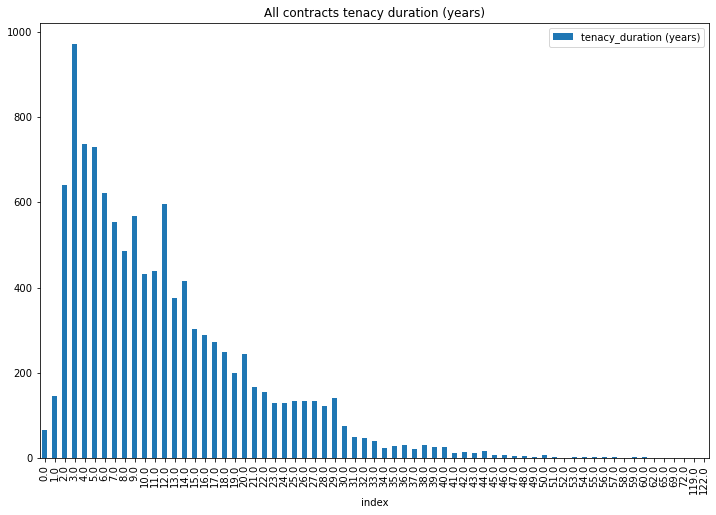

In [15]:
tenacy_data['tenacy_duration (years)'].value_counts().reset_index().sort_values('index').set_index('index').plot.bar(figsize = (12,8), title = "All contracts tenacy duration (years)")

In [16]:
# Each tenant has only lived to one apartment
print(tenacy_data.shape[0], tenacy_data.drop_duplicates(subset = ['unit_ref', 'tenancy_id']).shape[0]) # check for duplicates
tenacy_data.groupby(['tenancy_id'])['unit_ref'].count().reset_index().sort_values('unit_ref', ascending = False).head()

11102 11102


,tenancy_id,unit_ref
0,Tenant0,1
7405,Tenant6671,1
7397,Tenant6664,1
7398,Tenant6665,1
7399,Tenant6666,1


(1698, 11)


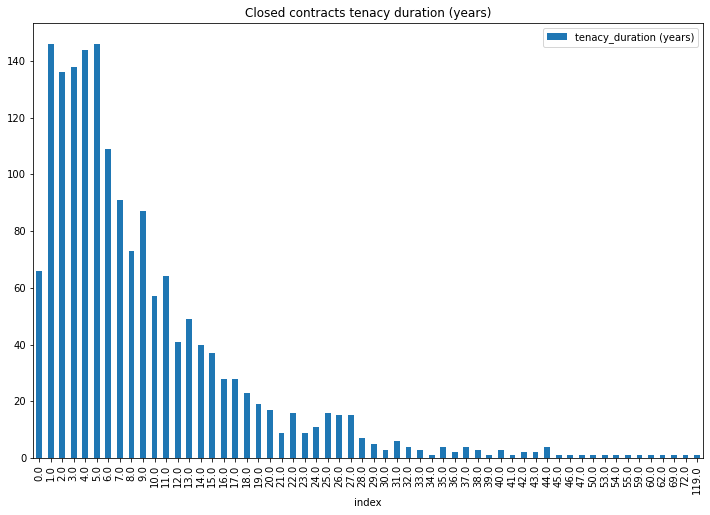

In [17]:
# Closed contracts
closed_contracts = tenacy_data[tenacy_data['Status'] == 'Closed']
print(closed_contracts.shape)
closed_contracts['tenacy_duration (years)'].value_counts().reset_index().sort_values('index').set_index('index').plot.bar(figsize = (12,8), title = "Closed contracts tenacy duration (years)")

(9404, 11)


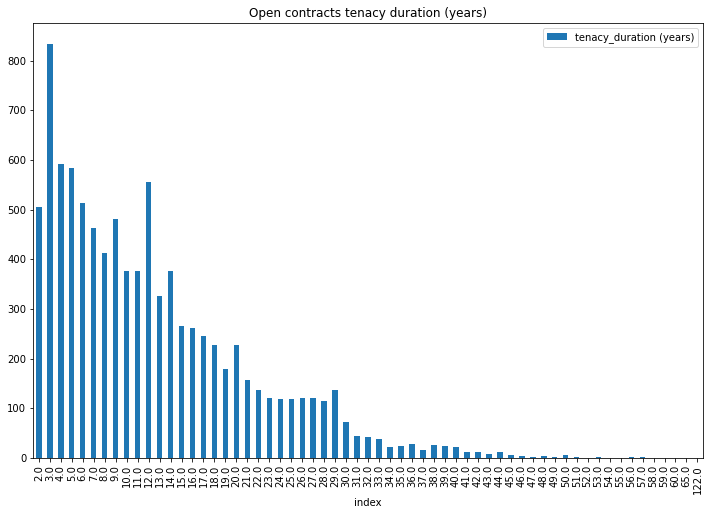

In [18]:
# Open contracts
open_contracts = tenacy_data[tenacy_data['Status'] == 'Open']
print(open_contracts.shape)
open_contracts['tenacy_duration (years)'].value_counts().reset_index().sort_values('index').set_index('index').plot.bar(figsize = (12,8), title = "Open contracts tenacy duration (years)")

# Case data

In [19]:
case_data.head()
# which cases closes more effectively

,case_number,unit_ref,unit_build_year,case_status,case_type,case_sub_type,case_create_date
0,Case0,Unit8230,2005.0,Resolved,ASB,NaN,21/02/2019 10:20
1,Case1,Unit7377,1880.0,Resolved,Service Charges,Invoice/Breakdown Request,20/05/2019 08:23
2,Case2,Unit2402,2008.0,Resolved,ASB,NaN,20/05/2019 08:47
3,Case3,Unit9567,1935.0,Resolved,Query,NaN,20/05/2019 08:55
4,Case4,Unit7956,2014.0,Resolved,Query,NaN,20/05/2019 09:04


In [20]:
case_data['case_create_date_as_date'] = case_data['case_create_date'].apply(lambda x :  datetime.strptime(x, '%d/%m/%Y %H:%M'))
case_data['quarter'] = pd.PeriodIndex(case_data.case_create_date_as_date, freq='Q')

In [112]:
case_data['case_type'].value_counts()

Query                    16659
Income                    6623
Direct Maintenance        5342
Complaints                3930
No Access                 3615
Service Charges           3512
Home Ownership            1752
ASB                       1481
Tenancy Change            1245
MP/Councillor Enquiry      743
Rehousing                  452
Death of Tenant            307
Disrepair                  290
Tenancy Visits             150
Abandonment                134
Possession                  66
Name: case_type, dtype: int64

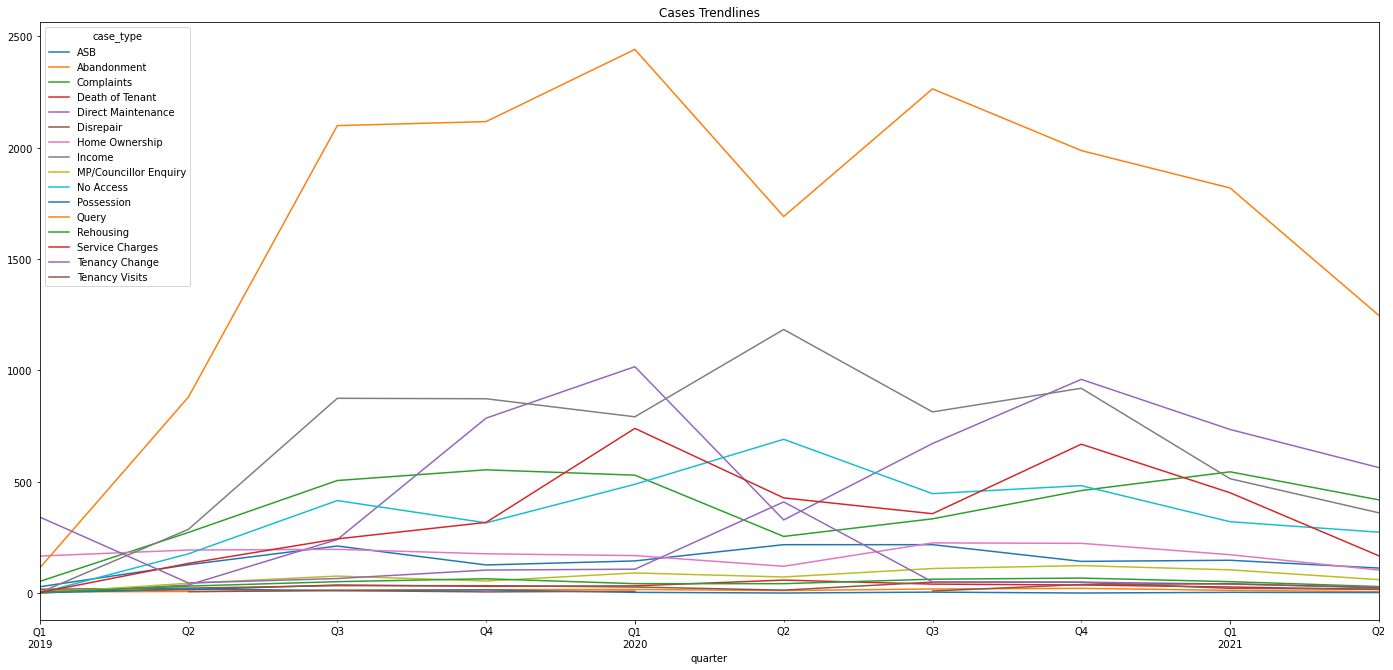

In [44]:
pd.pivot_table(case_data, index='case_type', columns='quarter',values='case_number',aggfunc='count').T.plot(figsize = (24,11), title="Cases Trendlines")

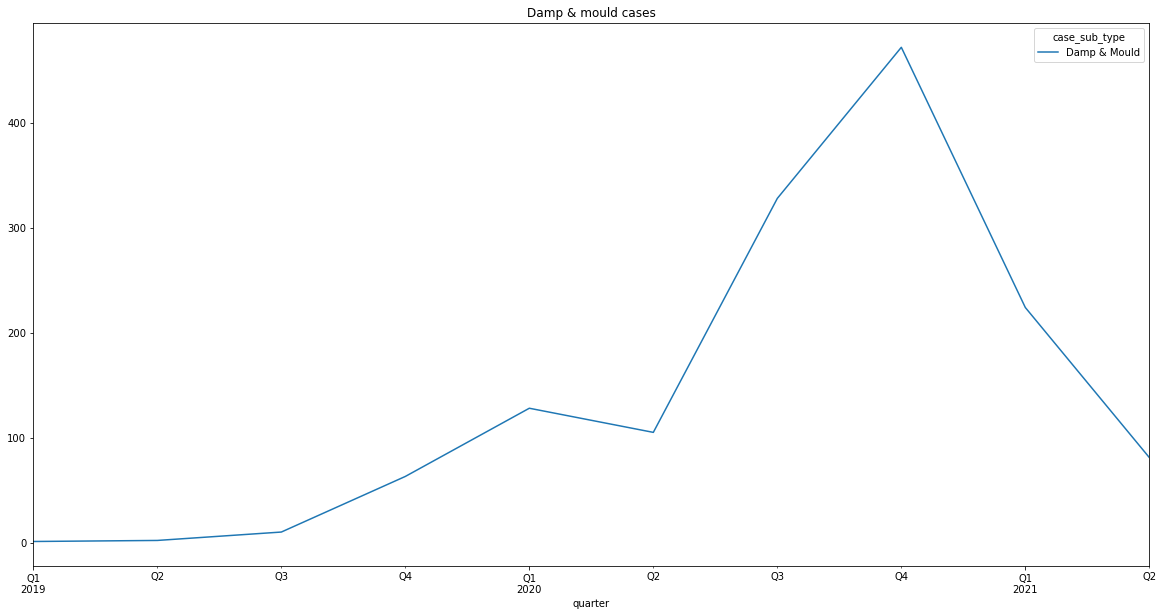

In [45]:
pd.pivot_table(case_data[case_data['case_sub_type'] == 'Damp & Mould'], index='case_sub_type', columns='quarter',values='case_number',aggfunc='count').T.plot(figsize = (20,10), title="Damp & mould cases")
# It looks like this graph is the merging of increase of mould during colder months and covid

There is some seasonality in this graph above and the mould cases increase during colder months. An assumption why the mould cases increased significanlty from 2019 to 2020 is because of COVID, during which people spent more time at their homes.

In [23]:
# Merge cases and tenancy datasets
# Set as closing date the current date for the open contracts so that we can do comparisons with end date
tenacy_data['tenancy_end_date_as_date'] = tenacy_data['tenancy_end_date_as_date'].apply(lambda x : datetime.now() if str(x) == 'NaT' else x)

# Filter out wrong rows that came out of the merging
print(case_data.shape, tenacy_data.shape)
units_cases_df =case_data.merge(tenacy_data, on = 'unit_ref')
units_cases_df = units_cases_df[units_cases_df['case_create_date_as_date'] >= units_cases_df['tenancy_start_date_as_date']]
units_cases_df = units_cases_df[units_cases_df['case_create_date_as_date'] <= units_cases_df['tenancy_end_date_as_date']]
print(units_cases_df.shape)

units_cases_df['time_until_the_case (days)'] = units_cases_df.apply(lambda row :( row['case_create_date_as_date'] - row['tenancy_start_date_as_date']).days, axis = 1 )

(46301, 9) (11102, 11)
(45364, 19)


In [24]:
# Merge unit_cases with vulnerability
units_cases_df = units_cases_df.merge(vulnerability_data_packed, on = 'tenancy_id', how= 'left')

# Add features
units_cases_df['number of vulnerabilities'] = units_cases_df['Vulnerability'].apply(lambda x : 0 if str(x) == 'nan' else len(x))
units_cases_df['Vulnerability'] = units_cases_df['Vulnerability'].apply(lambda x : x if isinstance(x, list) else ['Healthy'])
units_cases_df['Vulnerability type'] = units_cases_df['Vulnerability type'].apply(lambda x : x if isinstance(x, list) else ['No vulnerability'])

# Month of the case (possibly during winter periods Damp is a most common phenomenon
units_cases_df['case_month'] = units_cases_df['case_create_date_as_date'].apply(lambda x : x.month)

# Fillnas with mean built year value
mean_build_year = int(units_cases_df.dropna(subset = ['unit_build_year'])['unit_build_year'].mean())
units_cases_df['unit_build_year'].fillna(mean_build_year, inplace= True)

# Label
units_cases_df['label'] = units_cases_df['case_sub_type'].apply(lambda x : 1 if x == 'Damp & Mould' else 0)

In [25]:
# Duplicated case numbers because some tenants are leaving together
units_cases_df[units_cases_df['case_number'].duplicated()]

,case_number,unit_ref,unit_build_year,case_status,case_type,case_sub_type,case_create_date,case_create_date_as_date,quarter,tenancy_id,...,tenancy_duration (days),tenacy_duration (months),tenacy_duration (6- months),tenacy_duration (years),time_until_the_case (days),Vulnerability,Vulnerability type,number of vulnerabilities,case_month,label
15830,Case41027,Unit9707,2015.0,Resolved,Query,NaN,13/11/2019 13:38,2019-11-13 13:38:00,2019Q4,Tenant8463,...,1007,34.0,6.0,3.0,9,[Healthy],[No vulnerability],0,11,0
15832,Case41429,Unit9707,2015.0,Resolved,Query,NaN,20/11/2019 11:24,2019-11-20 11:24:00,2019Q4,Tenant8463,...,1007,34.0,6.0,3.0,16,[Healthy],[No vulnerability],0,11,0
31733,Case45024,Unit131,1890.0,Resolved,ASB,NaN,21/01/2020 09:43,2020-01-21 09:43:00,2020Q1,Tenant7054,...,930,31.0,5.0,3.0,1,[Healthy],[No vulnerability],0,1,0
34412,Case12553,Unit8541,1974.0,Resolved,Income,Tenancy Enquiry,10/07/2020 15:27,2020-07-10 15:27:00,2020Q3,Tenant1492,...,1360,45.0,8.0,4.0,602,[Healthy],[No vulnerability],0,7,0
34414,Case19118,Unit8541,1974.0,Resolved,Income,Refund Enquiry,05/10/2020 14:02,2020-10-05 14:02:00,2020Q4,Tenant1492,...,1360,45.0,8.0,4.0,689,[Healthy],[No vulnerability],0,10,0
39211,Case17886,Unit9601,2018.0,Resolved,Income,Refund Enquiry,21/09/2020 14:21,2020-09-21 14:21:00,2020Q3,Tenant3726,...,1364,45.0,8.0,4.0,679,[Healthy],[No vulnerability],0,9,0
40377,Case19542,Unit6829,2018.0,Resolved,Income,Refund Enquiry,08/10/2020 11:46,2020-10-08 11:46:00,2020Q4,Tenant3107,...,1081,36.0,6.0,3.0,413,[Healthy],[No vulnerability],0,10,0


In [26]:
key = ['case_number', 'tenancy_id']
train_cols = ['unit_build_year', 'tenancy_duration (days)', 'time_until_the_case (days)', 'Vulnerability type', 'number of vulnerabilities', 'case_month']
test_cols = ['label']

# Features and label
X = units_cases_df[train_cols]
y = units_cases_df['label']

# One hot encode vulnerability
X = X.join(one_hot_encode_list(units_cases_df, 'Vulnerability type')).drop(columns = ['Vulnerability type'])

# Split train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Number of "Damp and Mould" that we have in the training and test set
print(y_train.sum(), y_test.sum())

991 420


In [53]:
X_test

,unit_build_year,tenancy_duration (days),time_until_the_case (days),number of vulnerabilities,case_month,No vulnerability,abuse_addiction,communication_difficulty,covid,family_difficulty,generic,mental_difficulty,movement_difficulty,other
9389,2015.0,2463,1551,0,2,1,0,0,0,0,0,0,0,0
7751,1997.0,3366,2633,0,8,1,0,0,0,0,0,0,0,0
10764,1950.0,3159,2252,0,2,1,0,0,0,0,0,0,0,0
20512,2014.0,1931,1120,1,5,0,0,0,0,0,0,0,1,0
38806,1993.0,3366,2746,0,11,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31970,1910.0,6733,6120,0,12,1,0,0,0,0,0,0,0,0
22227,1920.0,5431,4564,1,3,0,0,0,0,0,1,0,0,0
23665,1997.0,727,220,1,3,0,0,0,0,0,0,1,0,0
7223,1864.0,1952,924,0,10,1,0,0,0,0,0,0,0,0


# Classifier


In [27]:
try:
    dict_to_save_outputs = read_json_as_dict("accuracy_dict.json")
    print("There is an existing dictionary")
except:
    print("There is no existing dictionary")
    dict_to_save_outputs = {}

There is an existing dictionary


## Logistic Regression - Random Forest

In [110]:
features_list = [col for col in train_cols]
print(f"Test set size: {X_test.shape[0]}")
(LR_classifier, LR_predictions, LR_accuracy, LR_precision) = classify_data("LR", X_train, X_test, y_train, y_test)
dict_to_save_outputs = save_accuracy_to_dict(dict_to_save_outputs, "LR", features_list, LR_accuracy)
print(f"LR precision: {LR_precision}")
(RF_classifier, RF_predictions, RF_accuracy, RF_precision) = classify_data("RF", X_train, X_test, y_train, y_test)
dict_to_save_outputs = save_accuracy_to_dict(dict_to_save_outputs, "RF", features_list, RF_accuracy)
save_dict_as_json("accuracy_dict.json",dict_to_save_outputs)
print(f" Random Forest precision: {RF_precision}")

Test set size: 13610
LR
Accuracy of LR classifier on test set: 0.9691
LR precision: 0.0
RF


/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of RF classifier on test set: 0.9645
 Random Forest precision: 0.08


In [107]:
RF_precision

0.08

# Feature Importance

Feature 0: unit_build_year, Score :0.1640
Feature 1: tenancy_duration (days), Score :0.2841
Feature 2: time_until_the_case (days), Score :0.3948
Feature 3: number of vulnerabilities, Score :0.0150
Feature 4: case_month, Score :0.1020
Feature 5: No vulnerability, Score :0.0028
Feature 6: abuse_addiction, Score :0.0027
Feature 7: communication_difficulty, Score :0.0047
Feature 8: covid, Score :0.0051
Feature 9: family_difficulty, Score :0.0003
Feature 10: generic, Score :0.0072
Feature 11: mental_difficulty, Score :0.0062
Feature 12: movement_difficulty, Score :0.0065
Feature 13: other, Score :0.0046


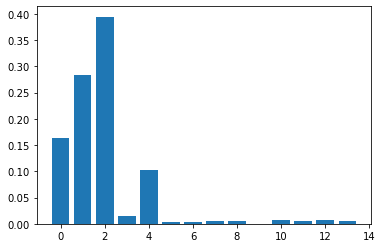

In [29]:
# Random Forest - Feature Importance
importance = RF_classifier.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print("Feature {}: {}, Score :{:.4f}".format(i,X.columns[i],v))
    # print('Feature: {} , Score: %.5f' % (X.columns[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [52]:
features_names = list(X.columns)
Feataure_Importance_df = pd.DataFrame(list(zip(features_names, list(importance))), columns = ['Feature', "Importance"])
Feataure_Importance_df.sort_values('Importance', ascending=False).to_clipboard()

## XGBoost

In [31]:
# Grid search
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters = {
    'max_depth': [2,8,10, 20],
    'n_estimators': [5, 20, 50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=True
)
grid_search.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use

KeyboardInterrupt: 

In [ ]:
grid_search.best_estimator_c

In [109]:
features_list = [col for col in train_cols]
(XGB_classifier, XGB_predictions, XGB_accuracy, XGB_precision) = classify_data("XGBoost", X_train, X_test, y_train, y_test)
dict_to_save_outputs = save_accuracy_to_dict(dict_to_save_outputs, "XGBoost", features_list, XGB_accuracy)
save_dict_as_json("accuracy_dict.json",dict_to_save_outputs)
print(XGB_precision)

XGBoost
[13:47:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kleomeniskogias/opt/anaconda3/envs/classifiers/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Accuracy of XGBoost classifier on test set: 0.9689
0.2


# Conclusion

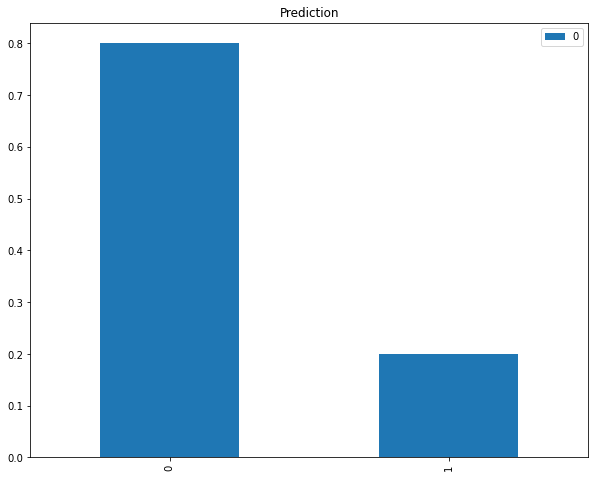

In [51]:
pd.DataFrame(data = {'0': [0.8], '1': [0.2]}).T.plot.bar(figsize = (10,8), title = "Prediction")
# vulnerability_data['Vulnerability'].value_counts().reset_index().sort_values('Vulnerability', ascending = False).set_index('index').plot.bar(figsize = (20,8), title = "Vulnerability bar chart")

We achieve slightly better accuracy with Logistic Regression compared to XGBoost while the worst accuracy is achieved by Random Forest.

In [33]:
print (f"The results are not sufficiently good with neither of the classifiers because there are {round(y_test.sum()/y_test.shape[0],6) * 100} % mould cases in the test set")

The results are not sufficiently good with neither of the classifiers because there are 3.086 % mould cases in the test set


# Probability Estimation

In [34]:
# Probability to find mould in each submission of the test set
estimate_probability(LR_classifier, X_test)

0        0.015125
1        0.029436
2        0.017810
3        0.020045
4        0.040212
           ...   
13605    0.060903
13606    0.024146
13607    0.021264
13608    0.031296
13609    0.041380
Name: 1, Length: 13610, dtype: float64

# Misclassified data

In [35]:
test_df = X_test.copy()
test_df['Actual'] = y_test
test_df['Predicted'] = LR_predictions
# test_df['Label 0'] = np.array(proba_with_labels[0])
test_df['Label 1'] = np.array(estimate_probability(LR_classifier, X_test))
test_df[test_df['Actual'] != test_df['Predicted']]

,unit_build_year,tenancy_duration (days),time_until_the_case (days),number of vulnerabilities,case_month,No vulnerability,abuse_addiction,communication_difficulty,covid,family_difficulty,generic,mental_difficulty,movement_difficulty,other,Actual,Predicted,Label 1
41220,1940.0,4052,3398,0,10,1,0,0,0,0,0,0,0,0,1,0,0.041667
27053,1996.0,769,232,0,2,1,0,0,0,0,0,0,0,0,1,0,0.019206
10949,1993.0,3646,2739,1,2,0,0,0,1,0,0,0,0,0,1,0,0.017125
7705,1880.0,4990,4242,0,7,1,0,0,0,0,0,0,0,0,1,0,0.036684
8899,1899.0,4318,3782,1,2,0,0,0,1,0,0,0,0,0,1,0,0.028509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40693,1860.0,6544,5882,0,10,1,0,0,0,0,0,0,0,0,1,0,0.055012
9641,1900.0,8588,7679,0,2,1,0,0,0,0,0,0,0,0,1,0,0.026845
7080,1991.0,923,93,0,4,1,0,0,0,0,0,0,0,0,1,0,0.017824
31970,1910.0,6733,6120,0,12,1,0,0,0,0,0,0,0,0,1,0,0.060903


In [36]:
# External data that would help:
# temperature in london
# covid data
# area of the apartment is missing
# floor of apartment and type of apartment
# how many people are living in the apartment

In [54]:
# Visualisations

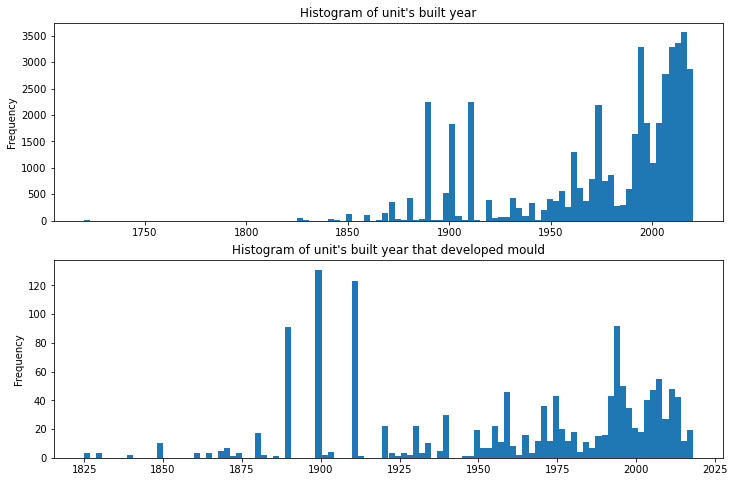

In [69]:
import matplotlib.pyplot as plt
nrow =2
ncol = 1
fig, axes = plt.subplots(nrow, ncol)
plt.figure(1)

units_cases_df['unit_build_year'].plot.hist(bins = 100, title = "Histogram of unit's built year", ax=axes[0])
units_cases_df[units_cases_df['label'] == 1]['unit_build_year'].plot.hist(bins = 100,title = "Histogram of unit's built year that developed mould", ax = axes[1], figsize=[12,8])

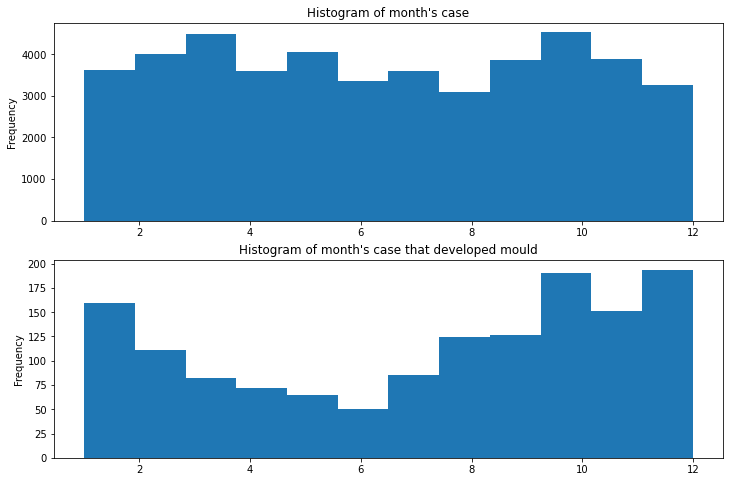

In [74]:

nrow =2
ncol = 1
fig, axes = plt.subplots(nrow, ncol)
plt.figure(1)

units_cases_df['case_month'].plot.hist(bins = 12, title = "Histogram of month's case", ax=axes[0]) # ax=axes[0]
units_cases_df[units_cases_df['label'] == 1]['case_month'].plot.hist(bins = 12,title = "Histogram of month's case that developed mould",figsize=[12,8], ax=axes[1])

In [77]:
units_cases_df['time_until_the_case (months)'].max()

KeyError: 'time_until_the_case (months)'

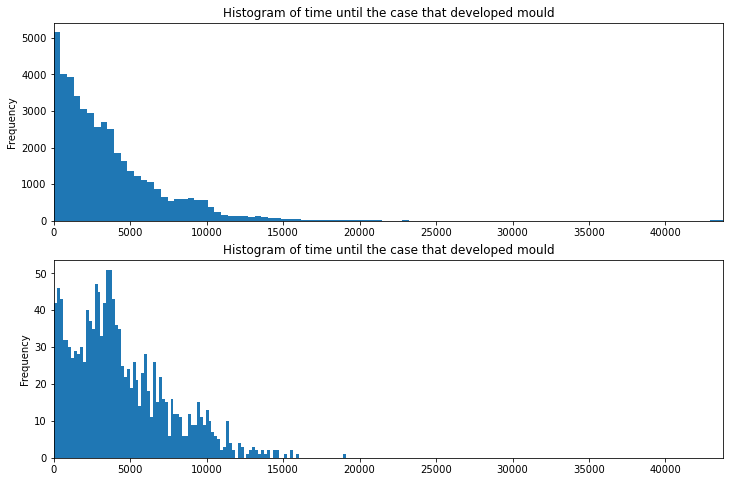

In [101]:
nrow =2
ncol = 1
fig, axes = plt.subplots(nrow, ncol)
plt.figure(1)
units_cases_df['time_until_the_case (days)'].plot.hist(bins = 100,title = "Histogram of time until the case that developed mould",figsize=[12,8], ax=axes[0], xlim = [units_cases_df['time_until_the_case (days)'].min(), units_cases_df['time_until_the_case (days)'].max()])
units_cases_df[units_cases_df['label'] == 1]['time_until_the_case (days)'].plot.hist(bins = 100,title = "Histogram of time until the case that developed mould",figsize=[12,8], ax=axes[1], xlim = [units_cases_df['time_until_the_case (days)'].min(), units_cases_df['time_until_the_case (days)'].max()])

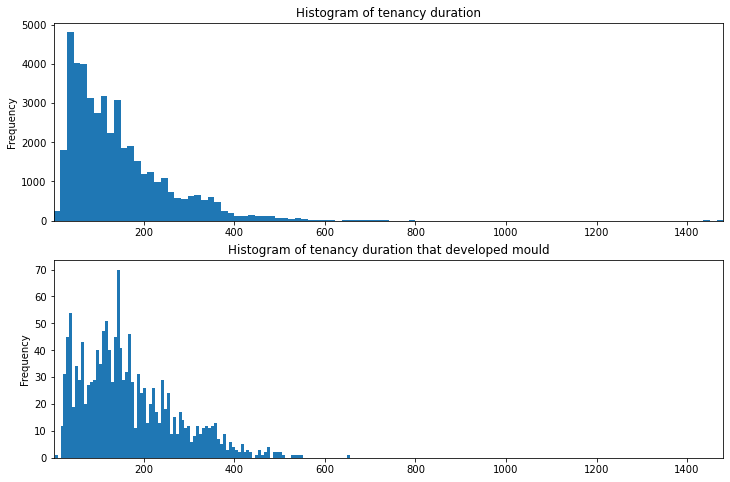

In [96]:
nrow =2
ncol = 1
fig, axes = plt.subplots(nrow, ncol)
plt.figure(1)

units_cases_df['tenacy_duration (months)'].plot.hist(bins = 100, title = "Histogram of tenancy duration", ax=axes[0], xlim= [units_cases_df['tenacy_duration (months)'].min(),units_cases_df['tenacy_duration (months)'].max()])
units_cases_df[units_cases_df['label'] == 1]['tenacy_duration (months)'].plot.hist(bins = 100,title = "Histogram of tenancy duration that developed mould",figsize=[12,8], ax=axes[1], xlim= [units_cases_df['tenacy_duration (months)'].min(),units_cases_df['tenacy_duration (months)'].max()])

In [98]:
units_cases_df['tenacy_duration (months)'].describe()

count    45364.000000
mean       140.938299
std        105.663720
min          1.000000
25%         62.000000
50%        113.000000
75%        189.000000
max       1480.000000
Name: tenacy_duration (months), dtype: float64

In [97]:
units_cases_df[units_cases_df['label'] == 1]['tenacy_duration (months)'].describe()

count    1411.000000
mean      166.368533
std       104.708628
min         3.000000
25%        91.500000
50%       144.000000
75%       225.000000
max       655.000000
Name: tenacy_duration (months), dtype: float64

In [87]:
print(units_cases_df['tenacy_duration (months)'].min(), units_cases_df['tenacy_duration (months)'].max())

1.0 1480.0
